In [27]:
import sys
!"{sys.executable}" -m pip install ucimlrepo


In [28]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

In [29]:
import sys
!"{sys.executable}" -m pip install matplotlib
import sys

# Install scikit-learn
!"{sys.executable}" -m pip install scikit-learn

# Install PyTorch (CPU-only)
!"{sys.executable}" -m pip install torch torchvision torchaudio

#Install Seaborn
import sys
!"{sys.executable}" -m pip install seaborn


In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# 1) Load dataset
# -----------------------------
dataset = fetch_ucirepo(id=697)

X = dataset.data.features.values.astype(np.float32)
y = dataset.data.targets.values.ravel()   # flatten to 1D

# Convert categorical target labels (e.g., 'Graduate') into integers (0,1,2)
le = LabelEncoder()
y = le.fit_transform(y)

num_classes = len(np.unique(y))
print("Number of classes:", num_classes)
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Number of classes: 3
Class mapping: {'Dropout': np.int64(0), 'Enrolled': np.int64(1), 'Graduate': np.int64(2)}


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert targets to numpy arrays explicitly (fix for TensorDataset)
y_train = np.array(y_train, dtype=np.int64)
y_val   = np.array(y_val, dtype=np.int64)
y_test  = np.array(y_test, dtype=np.int64)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)


In [33]:
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val).long()
)
test_ds = TensorDataset(
    torch.from_numpy(X_test),
    torch.from_numpy(y_test).long()
)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [34]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, num_classes)  # num_classes = 3 (Dropout, Enrolled, Graduate)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [35]:
def evaluate(loader):
    model.eval()
    total_loss, total_correct, total_count = 0.0, 0, 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_count += xb.size(0)
    return total_loss / total_count, total_correct / total_count

epochs = 30
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, epochs+1):
    model.train()
    running_loss, running_correct, running_count = 0.0, 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        running_correct += (preds == yb).sum().item()
        running_count += xb.size(0)

    train_epoch_loss = running_loss / running_count
    train_epoch_acc  = running_correct / running_count
    val_epoch_loss, val_epoch_acc = evaluate(val_loader)

    history['train_loss'].append(train_epoch_loss)
    history['val_loss'].append(val_epoch_loss)
    history['train_acc'].append(train_epoch_acc)
    history['val_acc'].append(val_epoch_acc)

    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_epoch_loss:.4f} val_loss={val_epoch_loss:.4f} "
              f"train_acc={train_epoch_acc:.4f} val_acc={val_epoch_acc:.4f}")


Epoch 01/30 | train_loss=0.8549 val_loss=0.6555 train_acc=0.6432 val_acc=0.7359
Epoch 05/30 | train_loss=0.5382 val_loss=0.5770 train_acc=0.7796 val_acc=0.7684
Epoch 10/30 | train_loss=0.4822 val_loss=0.5904 train_acc=0.8071 val_acc=0.7627
Epoch 15/30 | train_loss=0.4388 val_loss=0.6074 train_acc=0.8312 val_acc=0.7655
Epoch 20/30 | train_loss=0.3971 val_loss=0.6264 train_acc=0.8474 val_acc=0.7599
Epoch 25/30 | train_loss=0.3699 val_loss=0.6674 train_acc=0.8587 val_acc=0.7401
Epoch 30/30 | train_loss=0.3412 val_loss=0.6877 train_acc=0.8767 val_acc=0.7613


In [36]:
model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

print("\nClassification Report:")
print(classification_report(all_true, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

     Dropout       0.76      0.72      0.74       284
    Enrolled       0.42      0.39      0.40       159
    Graduate       0.81      0.86      0.83       442

    accuracy                           0.73       885
   macro avg       0.66      0.66      0.66       885
weighted avg       0.72      0.73      0.73       885



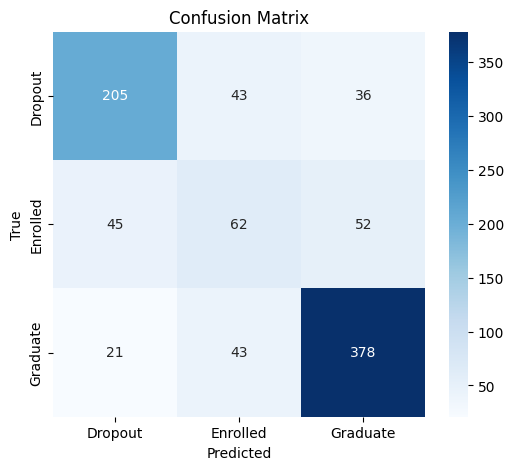

In [37]:
cm = confusion_matrix(all_true, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


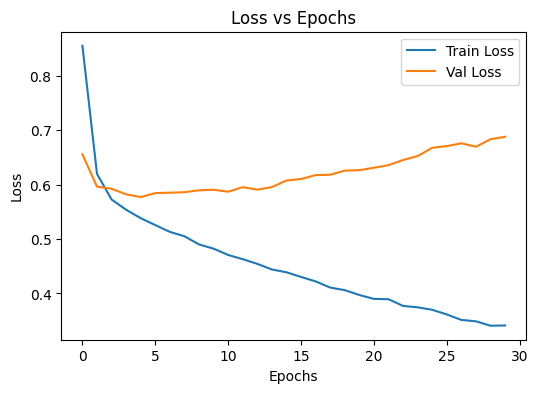

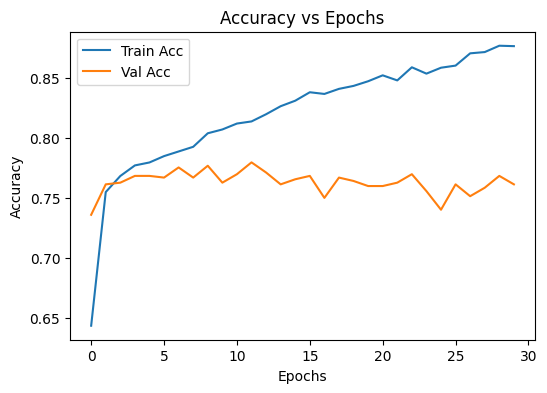

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss vs Epochs')
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy vs Epochs')
plt.show()